<a href="https://colab.research.google.com/github/Babitha23/Cyberbullying-detection/blob/main/sample_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import nltk
import string
import re
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


# Acquire Data

In [3]:
# Connect to google drive
drive.mount('/content/gdrive')

# Load data and set labels
data = pd.read_csv('gdrive/My Drive/Dissertation/final.csv', index_col='_unit_id')

Mounted at /content/gdrive


In [4]:
def cleancomments(text):
    tt = re.sub('\(created.at:\d\d\d\d-\d\d-\d\d \d\d:\d\d:\d\d\)', '', str(text)) #replacing comment time
    tt1 = re.sub('<font color\=\"\#0066CC\"\>.*?\<\/font>', '', str(tt)) # removing html tags with username
    tt2 = re.sub('@[^\s]+', '', str(tt1)) #removing user tag
    #Remove unicode strings like "\u002c" and "x96"
    tmp = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', tt2) 
    temp = re.sub(r'[^\x00-\x7f]',r'',tmp)
    #removing url
    temp1 = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',temp)
    temp2 = re.sub(r'#([^\s]+)', r'\1', temp1) # removing hashtags
    #removing emoticons
    temp3 = re.sub(':\)|;\)|:-\)|<3|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', temp2)
    temp4 = ''.join([i for i in temp3 if not i.isdigit()]) #removing numbers
    temp5 = re.sub(r"( ?\.)\1+", '.', temp4) #replacing multiple . with single .
    temp6 = re.sub(r"( ?\!)+", '!', temp5) #replacing multiple ! with single !
    temp7 = re.sub(r"( ?\?)+", '?', temp6) #replacing multiple ? with single ?
    #temp8 = re.sub(r"(\_)+", '', temp7)
    temp8 = ' '.join( [w for w in temp7.split() if len(w)>1]) #removing single characters
    temp9 = re.sub(' +', ' ', temp8) #removing additional whitespaces
    return temp9

In [5]:
data.columns

Index(['question1', 'question2', 'clmn1', 'clmn10', 'clmn100', 'clmn101',
       'clmn102', 'clmn103', 'clmn104', 'clmn105',
       ...
       'clmn95', 'clmn96', 'clmn97', 'clmn98', 'clmn99', 'likes', 'owner_cmnt',
       'shared media', 'followed_by', 'follows'],
      dtype='object', length=202)

In [6]:
df = data.drop(['likes','shared media','followed_by','follows'], axis=1)

Taking a sample of 10 datapoints with 50-50 positive-negatives

In [7]:
#taking samples with 50-50 split
aggdf_s = pd.concat([df.loc[df['question1'] == 'aggression'].tail(5), df.loc[df['question1'] == 'noneAgg'].tail(5)], axis=0).drop('question2', axis=1)
cybdf_s = pd.concat([df.loc[df['question2'] == 'bullying'].tail(5), df.loc[df['question2'] == 'noneBll'].tail(5)], axis=0).drop('question1', axis=1)

In [8]:
aggdf_s.isna().any().sum()

185

In [9]:
# aggdf_s = aggdf_s.replace('nan', np.NaN)
# cybdf_s = cybdf_s.replace('nan', np.NaN)

#Create new column with concat of all the comments excluding null values
aggdf_s['comments'] = aggdf_s.iloc[:, 1:-1].fillna('').agg('. '.join, axis=1)
cybdf_s['comments'] = cybdf_s.iloc[:, 1:-1].fillna('').agg('. '.join, axis=1)

#Remove individual comments columns
#data = data.drop(data.iloc[:, 2:197], axis=1)

# #concat owner's post along with comments
aggdf_s['sessiontext'] = aggdf_s['owner_cmnt'] + '. ' + aggdf_s['comments']
cybdf_s['sessiontext'] = cybdf_s['owner_cmnt'] + '. ' + cybdf_s['comments']

#Dropping owner_cmnt and comments columns
#data = data.drop(['owner_cmnt', 'comments'], axis=1)

aggdf_s = aggdf_s[['sessiontext', 'question1']]
cybdf_s = cybdf_s[['sessiontext', 'question2']]

In [10]:
cybdf_s

,sessiontext,question2
_unit_id,,
652910868,Eric Fisher gets ready for his headshot | <fo...,bullying
652910869,Shit cray !!!!. Rather your watch was real or...,bullying
652910870,"Camp life.. <font color=""#0066CC"">#MikeVickWe...",bullying
652910871,Signed over 300 pics at today's signing ! Fou...,bullying
652910876,"Next Stop: Knockout Round! <font color=""#0066...",bullying
652910867,Is the root of the problem the gun? Or the fi...,noneBll
652910872,"Skills! <font color=""#0066CC"">#sundayfunday</...",noneBll
652910873,"Lol <font color=""#0066CC"">#tupacamarushakur#t...",noneBll
652910874,Who cares right? There both just books? ___...,noneBll


In [11]:
#clean owner comments
for i in range(len(data)):
    aggdf_s['sessiontext'] = aggdf_s['sessiontext'].apply(lambda x: cleancomments(x))
    cybdf_s['sessiontext'] = cybdf_s['sessiontext'].apply(lambda x: cleancomments(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
aggdf_s

,sessiontext,question1
_unit_id,,
652910871,Signed over pics at today's signing! Found thi...,aggression
652910872,Skills! you don't want these problems!. Stick ...,aggression
652910874,Who cares right? There both just books? ______...,aggression
652910875,Media posted at -- dont like Ur mom e.e. And c...,aggression
652910876,Next Stop Knockout Round! defeated Croatia and...,aggression
652910861,Sorry but just had to do this. I'd cry and the...,noneAgg
652910862,It's time for LIKE THIS POST! Leave comment wi...,noneAgg
652910864,The Collar-Bomb Murder of Ana Elvia in Colombi...,noneAgg
652910867,Is the root of the problem the gun? Or the fin...,noneAgg


# Remove Punctuations

In [13]:
def removepunct(txt):
  remove = string.punctuation
  remove = remove.replace(".", "") # don't remove dot
  pattern = r"[{}]".format(remove) # create the pattern
  text = re.sub(pattern, "", txt)
  text = re.sub(' +', ' ', text) #remove additional whitespaces
  return text

In [14]:
for i in range(len(aggdf_s)):
  aggdf_s['sessiontext'] = aggdf_s['sessiontext'].apply(lambda x: removepunct(str(x)))

In [15]:
for i in range(len(cybdf_s)):
  cybdf_s['sessiontext'] = cybdf_s['sessiontext'].apply(lambda x: removepunct(str(x)))

In [16]:
aggdf_s

,sessiontext,question1
_unit_id,,
652910871,Signed over pics at todays signing Found this ...,aggression
652910872,Skills you dont want these problems Stick to d...,aggression
652910874,Who cares right There both just books cant sta...,aggression
652910875,Media posted at dont like Ur mom ee And cant f...,aggression
652910876,Next Stop Knockout Round defeated Croatia and ...,aggression
652910861,Sorry but just had to do this Id cry and then ...,noneAgg
652910862,Its time for LIKE THIS POST Leave comment with...,noneAgg
652910864,The CollarBomb Murder of Ana Elvia in Colombia...,noneAgg
652910867,Is the root of the problem the gun Or the fing...,noneAgg


# Stopword Removal

In [17]:
stopword = nltk.corpus.stopwords.words('english')
for i in range(10):
  aggdf_s['sessiontext'] = aggdf_s['sessiontext'].apply(lambda x: " ".join(x for x in x.split() if x not in stopword))
  cybdf_s['sessiontext'] = cybdf_s['sessiontext'].apply(lambda x: " ".join(x for x in x.split() if x not in stopword))

In [18]:
aggdf_s

,sessiontext,question1
_unit_id,,
652910871,Signed pics todays signing Found Playboy throw...,aggression
652910872,Skills dont want problems Stick drinking hoe F...,aggression
652910874,Who cares right There books cant stand SHEEP I...,aggression
652910875,Media posted dont like Ur mom ee And cant forg...,aggression
652910876,Next Stop Knockout Round defeated Croatia adva...,aggression
652910861,Sorry Id cry Id curl ball die Cry Idk freak \\...,noneAgg
652910862,Its time LIKE THIS POST Leave comment figurewh...,noneAgg
652910864,The CollarBomb Murder Ana Elvia Colombia When ...,noneAgg
652910867,Is root problem gun Or finger behind Or possib...,noneAgg


# Lemmatization

In [19]:
#st = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
for i in range(10):
  #aggdf_s[col] = aggdf_s[col].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
  #cybdf_s[col] = cybdf_s[col].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
  aggdf_s['sessiontext'] = aggdf_s['sessiontext'].apply(lambda x: " ".join([wn.lemmatize(word) for word in x.split()]))
  cybdf_s['sessiontext'] = cybdf_s['sessiontext'].apply(lambda x: " ".join([wn.lemmatize(word) for word in x.split()]))

In [20]:
aggdf_s = aggdf_s.rename(columns={'question1':'y1'})
cybdf_s = cybdf_s.rename(columns={'question2':'y2'})

Label encoding

In [21]:
aggdf_s['y1'] = aggdf_s['y1'].replace(['aggression','noneAgg'],[1,0])
cybdf_s['y2'] = cybdf_s['y2'].replace(['bullying','noneBll'],[1,0])

In [22]:
print(aggdf_s.columns)
print(cybdf_s.columns)

Index(['sessiontext', 'y1'], dtype='object')
Index(['sessiontext', 'y2'], dtype='object')


In [23]:
for i in range(10):
  aggdf_s['sessiontext'] = aggdf_s['sessiontext'].apply(lambda x: re.sub(r"( ?\.)\1+", '. ', str(x)))
  cybdf_s['sessiontext'] = cybdf_s['sessiontext'].apply(lambda x: re.sub(r"( ?\.)\1+", '. ', str(x)))

# Encode data

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, metrics, svm
from sklearn.svm import SVC

#TF-IDF

In [25]:
# TFIDF feature generation
# tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}')
# tfidf_vect.fit(X1)
# x1train_tfidf = tfidf_vect.transform(X1_train)
# x1test_tfidf = tfidf_vect.transform(X1_test)

# x2train_tfidf = tfidf_vect.transform(X2_train)
# x2test_tfidf = tfidf_vect.transform(X2_test)

# x2train_tfidf.data


def tfIdf_Vectorization(corpus):
  vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), sublinear_tf=True, use_idf=True)
  tdidf_tensor = vectorizer.fit_transform(corpus)
  return tdidf_tensor

corpus = aggdf_s['sessiontext'].values.astype('U')
agg_tdidf_tensor= tfIdf_Vectorization(corpus)
print('shape',agg_tdidf_tensor.shape)

corpus1 = cybdf_s['sessiontext'].values.astype('U')
cyb_tdidf_tensor= tfIdf_Vectorization(corpus1)
print('shape',cyb_tdidf_tensor.shape)

# Print the first 10 features
#print(tfidf_vectorizer.get_feature_names()[:10])

shape (10, 8574)
shape (10, 10839)


In [26]:
print("\n Aggression Vectors:")
print("====================")
print('shape',agg_tdidf_tensor.shape, "\n")
print(agg_tdidf_tensor.todense())

print("\n Cyberbullying Vectors:")
print("=======================")
print('shape',cyb_tdidf_tensor.shape, "\n")
print(cyb_tdidf_tensor.todense())


 Aggression Vectors:
shape (10, 8574) 

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.02015743 0.02015743]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.03430643 0.03430643 0.03430643 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

 Cyberbullying Vectors:
shape (10, 10839) 

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.02064983 0.02064983]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# BERT word embeddings

# XLNet word embeddings

# Test train split

In [27]:
X1 = agg_tdidf_tensor
X2 = cyb_tdidf_tensor
Y1 = aggdf_s['y1']
Y2 = cybdf_s['y2']

In [28]:
#Let's split our data for training
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1,Y1,test_size=0.2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,Y2,test_size=0.2)

In [29]:
Y2

_unit_id
652910868    1
652910869    1
652910870    1
652910871    1
652910876    1
652910867    0
652910872    0
652910873    0
652910874    0
652910875    0
Name: y2, dtype: int64

# Class Distribution

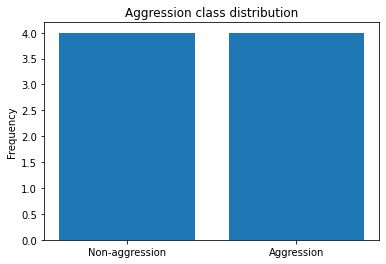

In [30]:
#Class distribution plot
plt.bar(y1_train.value_counts().index, y1_train.value_counts())
plt.title("Aggression class distribution")
plt.xticks([0,1],['Non-aggression','Aggression'])
plt.ylabel("Frequency")
plt.show()

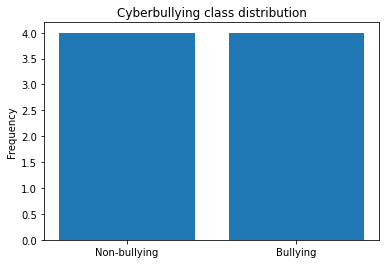

In [31]:
plt.bar(y2_train.value_counts().index, y2_train.value_counts())
plt.title("Cyberbullying class distribution")
plt.ylabel("Frequency")
plt.xticks([0,1],['Non-bullying','Bullying'])
plt.show()

# Resampling to handle class imbalance

Below code is only needed when we apply to the whole corpus.

In [32]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE()

# fit predictor and target variable
x1_smtrain, y1_smtrain = smote.fit_resample(X1_train, y1_train)
print("Agg Before Resampling:", Counter(y1_train))
print("Agg After Resampling:", Counter(y1_smtrain))

# fit predictor and target variable
x2_smtrain, y2_smtrain = smote.fit_resample(X2_train, y2_train)
print("\nCyb Before Resampling:", Counter(y2_train))
print("Cyb After Resampling:", Counter(y2_smtrain))

Agg Before Resampling: Counter({1: 4, 0: 4})
Agg After Resampling: Counter({1: 4, 0: 4})

Cyb Before Resampling: Counter({1: 4, 0: 4})
Cyb After Resampling: Counter({1: 4, 0: 4})


In [42]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, confusion_matrix, make_scorer, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold, GridSearchCV,cross_validate
from sklearn.ensemble import RandomForestClassifier

In [43]:
#Defining train model function that can be called to apply different ML models
def train_model(classifier, xtrain, ytrain, xtest):
    # fit the training dataset on the classifier
    classifier.fit(xtrain, ytrain)
    # predict the labels on validation dataset
    predictions = classifier.predict(xtest)
    return(predictions)

#Defining function to update classification reports in pandas dataframes
def get_classification_report(y_test, y_pred):
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report
    return df_classification_report

# Tradition Machine Learning (SVM, RF) + TFIDF

In [44]:
svc = LinearSVC(class_weight="balanced", random_state=42)
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

In [48]:
y1_svc_pred = train_model(svc, x1_smtrain, y1_smtrain, X1_test)
y2_svc_pred = train_model(svc, x2_smtrain, y2_smtrain, X2_test)

print(get_classification_report(y1_test, y1_svc_pred))
print(get_classification_report(y2_test, y2_svc_pred))

              precision  recall  f1-score  support
0                  0.00     0.0  0.000000      1.0
1                  0.50     1.0  0.666667      1.0
accuracy           0.50     0.5  0.500000      0.5
macro avg          0.25     0.5  0.333333      2.0
weighted avg       0.25     0.5  0.333333      2.0
              precision  recall  f1-score  support
0                  0.50     1.0  0.666667      1.0
1                  0.00     0.0  0.000000      1.0
accuracy           0.50     0.5  0.500000      0.5
macro avg          0.25     0.5  0.333333      2.0
weighted avg       0.25     0.5  0.333333      2.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [49]:
y1_rfc_pred = train_model(rfc, x1_smtrain, y1_smtrain, X1_test)
y2_rfc_pred = train_model(rfc, x2_smtrain, y2_smtrain, X2_test)

print(get_classification_report(y1_test, y1_rfc_pred))
print(get_classification_report(y2_test, y2_rfc_pred))

              precision  recall  f1-score  support
0                  0.50     1.0  0.666667      1.0
1                  0.00     0.0  0.000000      1.0
accuracy           0.50     0.5  0.500000      0.5
macro avg          0.25     0.5  0.333333      2.0
weighted avg       0.25     0.5  0.333333      2.0
              precision  recall  f1-score  support
0                  0.00     0.0  0.000000      1.0
1                  0.50     1.0  0.666667      1.0
accuracy           0.50     0.5  0.500000      0.5
macro avg          0.25     0.5  0.333333      2.0
weighted avg       0.25     0.5  0.333333      2.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

# Traditional Machine Learning (SVM, RF) + BERT embeddings

# Traditional Machine Learning (SVM, RF) + XLNet embeddings

# BiLSTM + BERT embeddings

# BiGRU + BERT embeddings